# Project 1 - Regression
## Predict total bikes that will be rented per day
### This notebook uses the *bike_day_v2.xlsx* 
Adaptation from Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

(c) Nuno António 2023 - Rev. 1.0

## Dataset description

- **instant**: record index
- **dteday** : date
- **season** : season (1:springer, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2011, 1:2012)
- **mnth** : month ( 1 to 12)
- **holiday** : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0
- **schoolday** : if day is a normal school day is 1, otherwise is 0
- **weathersit** : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

## Work description

### Overview
<p>Your customer whishes to build a model to predict everyday at 15h00 the total number of bikes they will rent the following day. This will allow them not only to better allocate staff resources, but also to define their daily marketing budget in social media which is their principal form of advertisement.</p>


# 1. Initializations and data loading

In [1]:
# Loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
!pip install yellowbrick
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from scipy.stats import chi2_contingency

In [2]:
# Loading the dataset and visualizing summary statistics

ds = pd.read_excel('bike_day_v2.xlsx', engine='openpyxl')
ds.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
instant,732.0,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
dteday,732,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732.0,2.497268,1.0,2.0,3.0,3.0,4.0,1.110203
yr,732.0,0.501366,0.0,0.0,1.0,1.0,1.0,0.50034
mnth,732.0,6.523224,1.0,4.0,7.0,10.0,12.0,3.450769
holiday,732.0,0.028689,0.0,0.0,0.0,0.0,1.0,0.167044
weekday,730.0,3.00274,0.0,1.0,3.0,5.0,6.0,2.004793
workingday,732.0,0.68306,0.0,0.0,1.0,1.0,1.0,0.465602
schoolday,454.0,0.460352,0.0,0.0,0.0,1.0,1.0,0.498975
weathersit,732.0,1.394809,1.0,1.0,1.0,2.0,3.0,0.544718


Summary statistics show that the average number of bike rentals is *4510* per day. The minimum count was *22* bikes a day and the maximum was *8714* bikes per day.


# 2. Data Exploration 1.0

In [3]:
# Show top rows of the dataset ds

ds.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6.0,0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0.0,0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1.0,1,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2.0,1,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3.0,1,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
# Check for missing values

print(ds.isnull().sum())

instant         0
dteday          0
season          0
yr              0
mnth            0
holiday         0
weekday         2
workingday      0
schoolday     278
weathersit      0
temp            0
atemp           0
hum             0
windspeed       0
casual          0
registered      0
cnt             0
dtype: int64


Looking at the missing values we observe that the attribute **Weekday** has 2 missing values, since this is a relatively low number we opted to keep the **Weekday** variable.
**Schoolday** has 278 (38%) missing values, this is a significant proportion of missing values and suggests this attribute would not be useful to our study and should be dropped.

In [5]:
# Check the type of each variable

ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    int64         
 3   yr          732 non-null    int64         
 4   mnth        732 non-null    int64         
 5   holiday     732 non-null    int64         
 6   weekday     730 non-null    float64       
 7   workingday  732 non-null    int64         
 8   schoolday   454 non-null    float64       
 9   weathersit  732 non-null    int64         
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

Assessing the datatypes we note that **year**, **mnth**, **season**, **weekday** and **weathersit** will need to be reclassified as categorical variables.

In [6]:
# Drop the columns 'Casual', 'Registered' and 'Instant'

ds.drop(columns=['casual','registered', 'instant'], inplace=True)


We dropped **registered** and **casual** because they are redundant since we can just use **cnt**. **Instant** was also dropped because it is just the record index and is thus irrelevant.

In [7]:
# Rename the columns

ds.rename(columns={'dteday':'date','yr':'year','mnth':'month','weathersit':'weathercondition'},inplace=True)

In [8]:
# Checking unique values for categorical columns

for col in ['season', 'year', 'month', 'weekday', 'holiday', 'workingday', 'weathercondition', 'schoolday']:
    print(f"{col} unique values: {ds[col].unique()}")

season unique values: [1 2 3 4]
year unique values: [0 1]
month unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12]
weekday unique values: [ 6.  0.  1.  2.  3.  4.  5. nan]
holiday unique values: [0 1]
workingday unique values: [0 1]
weathercondition unique values: [2 1 3]
schoolday unique values: [ 0.  1. nan]


The dataset seems to have relatively low to moderate cardinality in its categorical features, with the exception of the missing values in **weekday** and **schoolday**. This generally makes it easier to handle these features in machine learning models compared to datasets with high cardinality categorical columns (which can lead to the "curse of dimensionality" after one-hot encoding). However, the missing values need to be addressed properly before further analysis or modeling.

In [9]:
# Identify all duplicate rows

duplicates = ds[ds.duplicated(keep=False)]

duplicates

,date,season,year,month,holiday,weekday,workingday,schoolday,weathercondition,temp,atemp,hum,windspeed,cnt
623,2012-09-15,3,1,9,0,6.0,0,0.0,1,0.608333,0.585867,0.501667,0.247521,8714
624,2012-09-15,3,1,9,0,6.0,0,0.0,1,0.608333,0.585867,0.501667,0.247521,8714


Here we can see that there are only two duplicates, we can drop one.

# 3. Data Visualization of the dataset

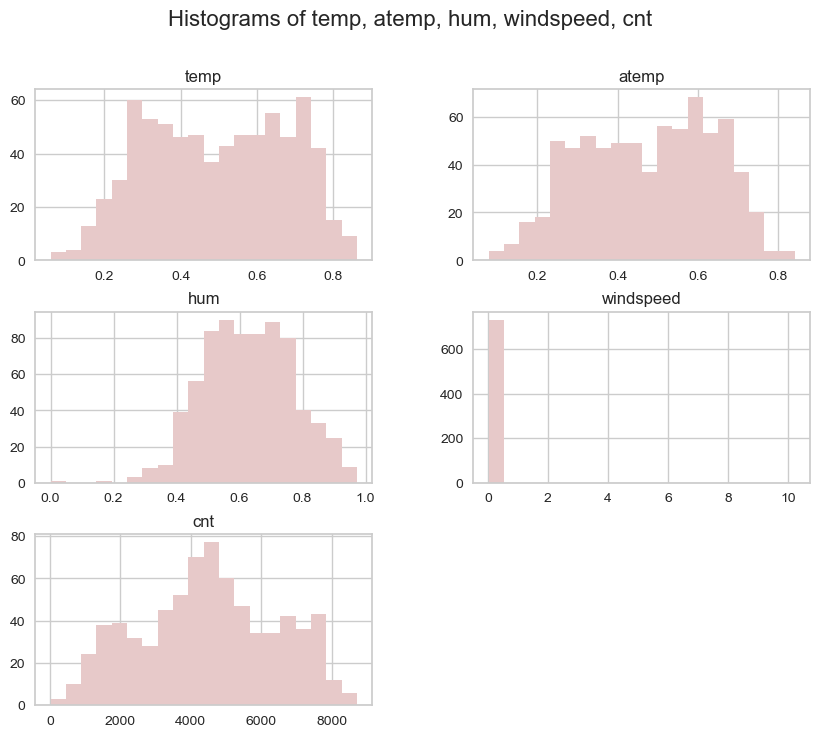

In [10]:
# Histograms of numerical variables

ds.hist(column=['temp', 'atemp', 'hum', 'windspeed', 'cnt'], 
        bins=20, 
        figsize=(10, 8), 
        color='#e7c9c9')  # Definindo a cor dos histogramas

plt.suptitle('Histograms of temp, atemp, hum, windspeed, cnt', fontsize=16)
plt.show()


- The variables **temp** and **atemp** have a fairly uniform distribution. There is no extreme skewness, which suggests temperature variations are well-distributed.  
- **Humidity** shows a close to normal distribution.  
- The **windspeed** histogram suggests an issue with the data. Values are concentrated around zero, indicating a possible data collection error. The issue is possibly the result of one or more extreme outliers.

<function matplotlib.pyplot.show(close=None, block=None)>

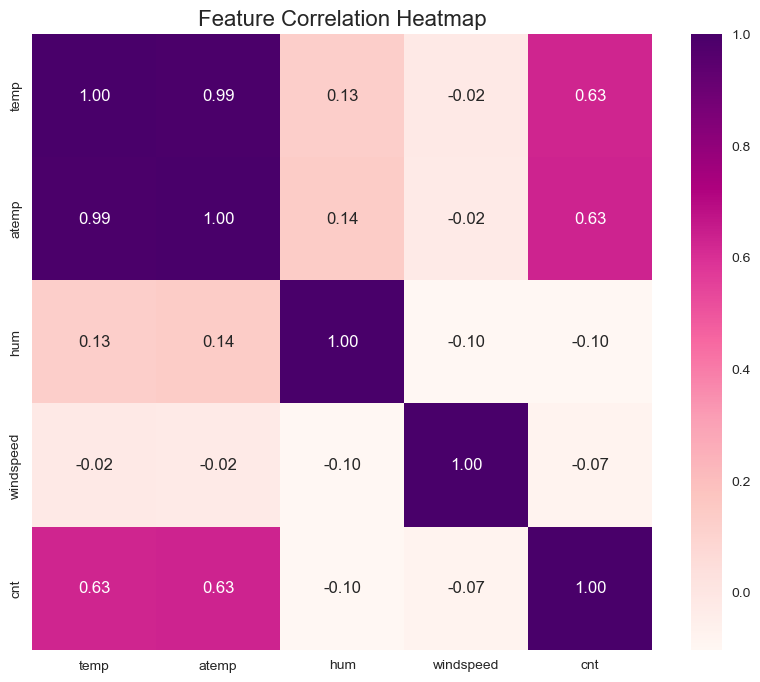

In [11]:
# Heatmap with correlations of numerical variables

plt.figure(figsize=(10, 8))
sns.heatmap(ds[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr(), annot=True, cmap="RdPu", fmt=".2f")
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show

The correlation heatmap shows that **temp** is highly correlated with **atemp** (correlation of 0.99). This being the case, we will need to drop one of the two in our feature selection to avoid redundancy. 
There is a moderate correlation between temperature and the number of bike rentals. This is to be expected as people are more likely to rent bikes in pleasant weather.

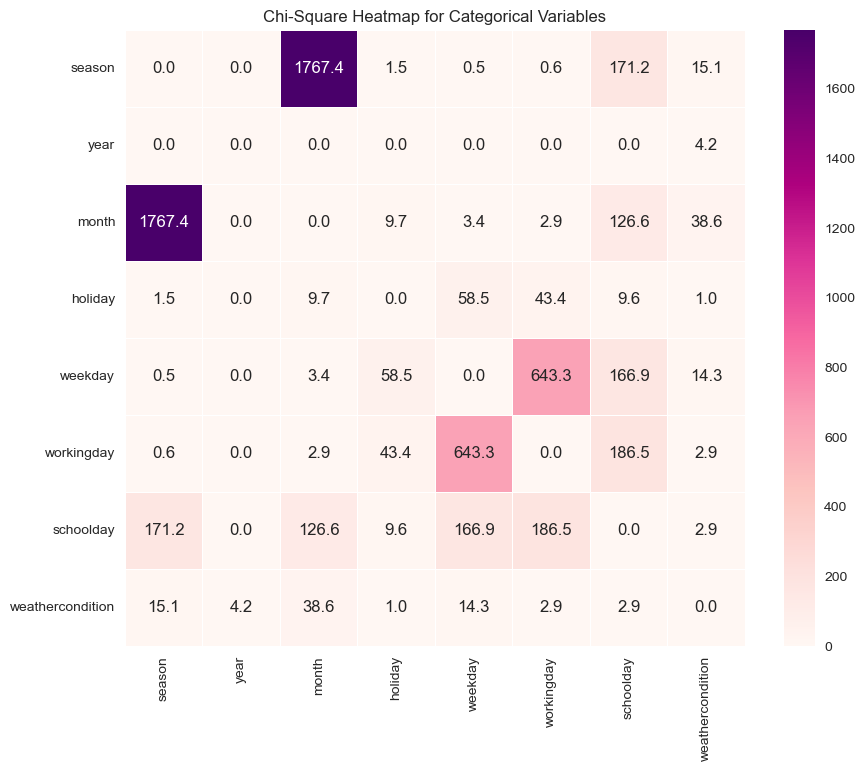

In [12]:
#Chi-Square Heatmap for Categorical Variables

# Define categorical columns in the dataset
categorical_cols = ["season", "year", "month", "holiday", "weekday", "workingday", "schoolday", "weathercondition"]

# Compute Chi-square values
chi2_matrix = np.zeros((len(categorical_cols), len(categorical_cols)))

for i, col1 in enumerate(categorical_cols):
    for j, col2 in enumerate(categorical_cols):
        if i >= j:
            continue  # Avoid redundant calculations and self-comparison
        contingency_table = pd.crosstab(ds[col1], ds[col2])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_matrix[i, j] = chi2
        chi2_matrix[j, i] = chi2  # Symmetric matrix

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_matrix, index=categorical_cols, columns=categorical_cols)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_df, annot=True, cmap="RdPu", fmt=".1f", linewidths=0.5)
plt.title("Chi-Square Heatmap for Categorical Variables")
plt.show()

The Chi-Square heatmap displays the relationships between categorical variables. Strong associations are indicated by high Chi-Square values; for instance, **month** and **season** exhibit a high degree of correlation. Conversely, low values suggest minimal or no association between the variables. This visualization helps in identifying dependencies among categorical features.

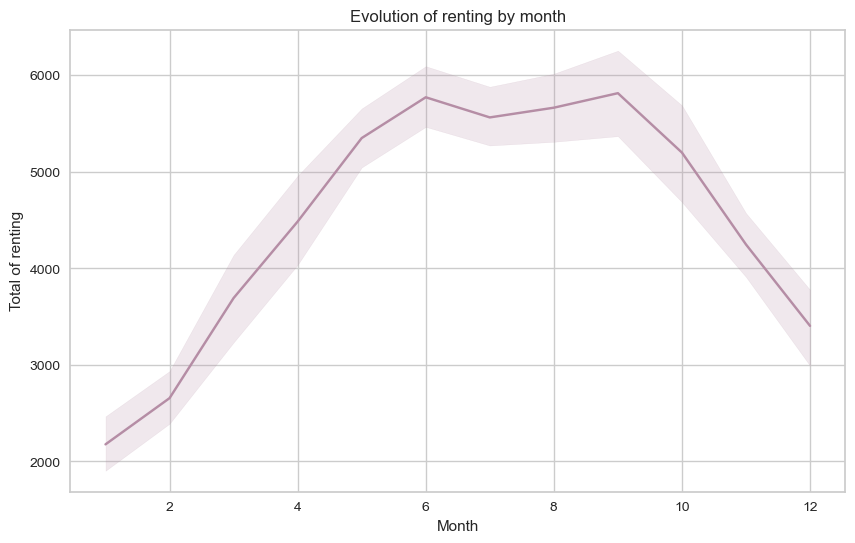

In [13]:
# Distribution of renting by month

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='cnt', data=ds, color="#b58da5")
plt.title('Evolution of renting by month')
plt.xlabel('Month')
plt.ylabel('Total of renting')
plt.xticks(rotation=0)
plt.show()

Here we can see that bike rentals gradually increase from January to June, peaking in the period between June and August. There is a steady decline in rentals after that,  leading up to December. This pattern suggests seasonal variations in bike rentals, with demand increasing in the summer months and possibly coinciding summer vacations. Seasonality appears to be a strong factor and should be included in the model by using either month or season attribute.

In [14]:
# Split the dataset into two subsets: one for 2011 (encoded as 0) and one for 2012 (encoded as 1)

ds_2011 = ds[ds['year'] == 0]
ds_2012 = ds[ds['year'] == 1]

In [15]:
# Table with the information of total rentings by year and month 

cross_table_month_2011 = ds_2011.pivot_table(values='cnt', index='month', aggfunc='sum')
cross_table_month_2012 = ds_2012.pivot_table(values='cnt', index='month', aggfunc='sum')

# Combine both tables into one
combined_cross_table = pd.concat([cross_table_month_2011, cross_table_month_2012], axis=1)
combined_cross_table.columns = ['2011', '2012']

# Add a 'Total' column by summing both years' values for each month
combined_cross_table['Total'] = combined_cross_table['2011'] + combined_cross_table['2012']

# Sort the table by month
combined_cross_table = combined_cross_table.sort_index()

# Display the table
combined_cross_table

,2011,2012,Total
month,,,
1,38189,96744,134933
2,48215,103137,151352
3,64045,164875,228920
4,94870,174224,269094
5,135821,195865,331686
6,143512,202830,346342
7,141341,203607,344948
8,136691,214503,351194
9,127418,227287,354705


C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\2508028152.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_2011['month'] = ds_2011['date'].dt.strftime('%b')
C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\2508028152.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_2012['month'] = ds_2012['date'].dt.strftime('%b')


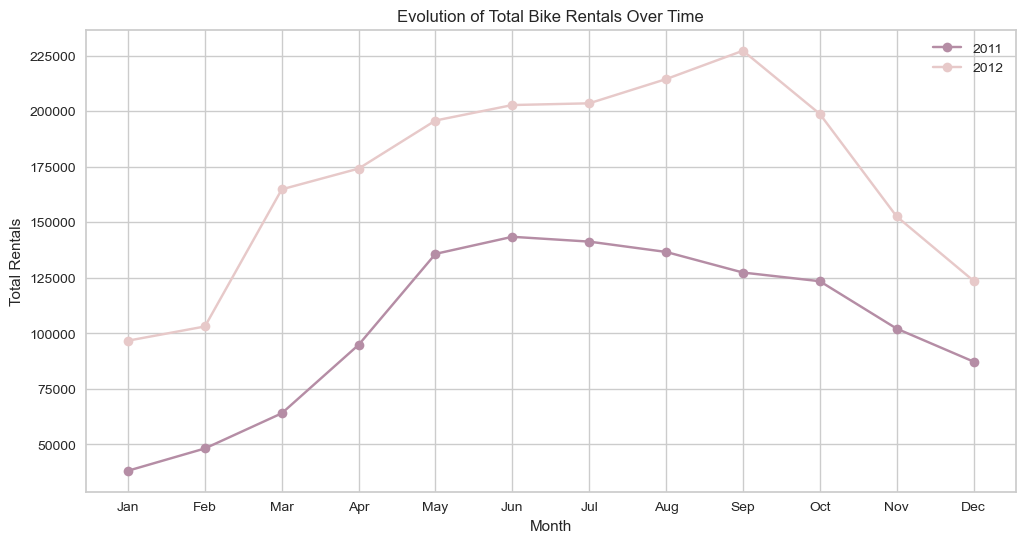

In [16]:
# Evolution of total bike rentas over time

# Define a darker color palette
palette = ["#b58da5", "#d46a87", "#e7c9c9", "#c4688a", "#d05694", "#c94792"]

# Months in order
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ds_2011['month'] = ds_2011['date'].dt.strftime('%b')
ds_2012['month'] = ds_2012['date'].dt.strftime('%b')

# Grouping total count by month
monthly_2011 = ds_2011.groupby('month')['cnt'].sum().reindex(months)
monthly_2012 = ds_2012.groupby('month')['cnt'].sum().reindex(months)

# Line plot with months on the x-axis and separate lines for 2011 and 2012
plt.figure(figsize=(12, 6))
plt.plot(months, monthly_2011, color=palette[0], marker='o', label='2011') 
plt.plot(months, monthly_2012, color=palette[2], marker='o', label='2012')  
plt.title('Evolution of Total Bike Rentals Over Time')
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.legend()
plt.show()

Comparing bike rental between the year 2011 and 2012, we see a similar pattern of changes in demand between Janaury and February. Bike rentals were consistently high in 2012 and in 2011. This suggests an overall increase in bike rentals, possibly due to greater awareness of the company, increase popularity of biking or other external factors.

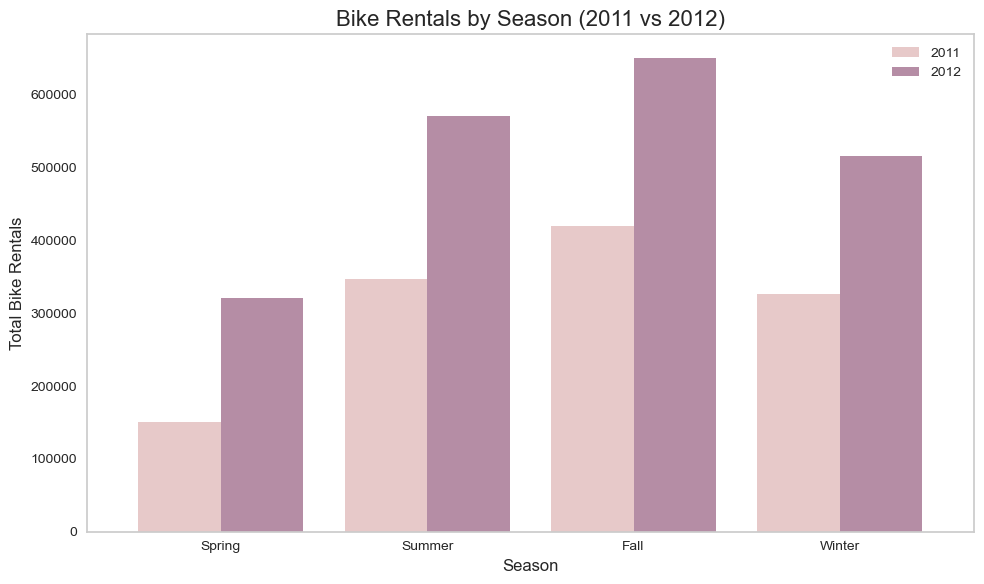

In [17]:
# Count plot with seasonal Bike Rentals Comparison: 2011 vs 2012

# Define a darker color palette
palette = ["#e7c9c9", "#b58da5"]

# Create the pivot table for seasonal bike rentals by year
cross_table_season = ds.pivot_table(values='cnt', index='season', columns='year', aggfunc='sum')
cross_table_season.columns = ["2011", "2012"]
cross_table_season.index = ["Spring", "Summer", "Fall", "Winter"]

# Plotting the data
ax = cross_table_season.plot(kind='bar', figsize=(10, 6), width=0.8, color=palette)

# Set the title and labels
ax.set_title("Bike Rentals by Season (2011 vs 2012)", fontsize=16)
ax.set_xlabel("Season", fontsize=12)
ax.set_ylabel("Total Bike Rentals", fontsize=12)

# Customize x-axis tick labels and add grid
plt.xticks(rotation=0)
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


This figure shows again that bike rentals were higher in 2012 than in 2011 in each of the four seasons. Demand was highest in the fall season and lowest in the spring in both years.

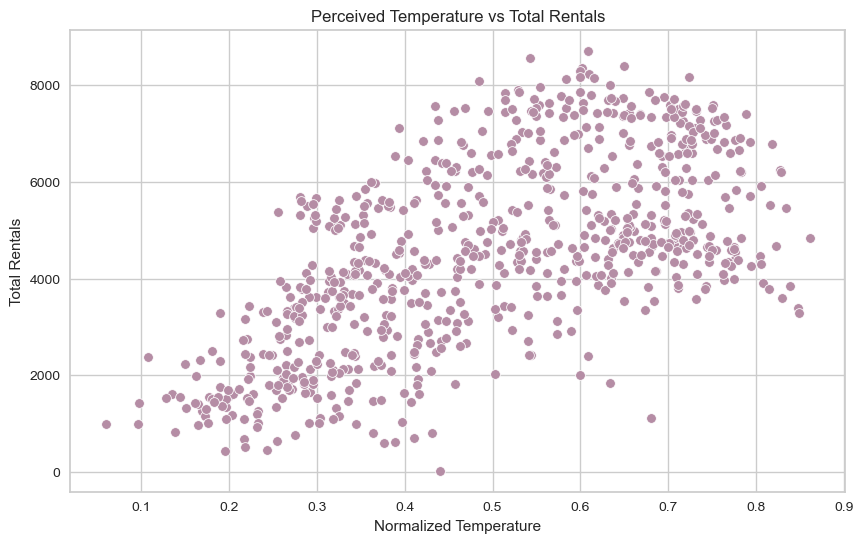

In [18]:
# Perceived temperature vs total rentals

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='cnt', data=ds, color="#b58da5")  # Custom pastel pink color

# Adding a title and labels
plt.title('Perceived Temperature vs Total Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Total Rentals')

# Show the plot
plt.show()

Here we see a positive correlation between perceived temperature and total rentals. As the temperature increases, the number of bike rentals also tends to increase. This suggests that warmer weather is associated with higher bike rental activity.

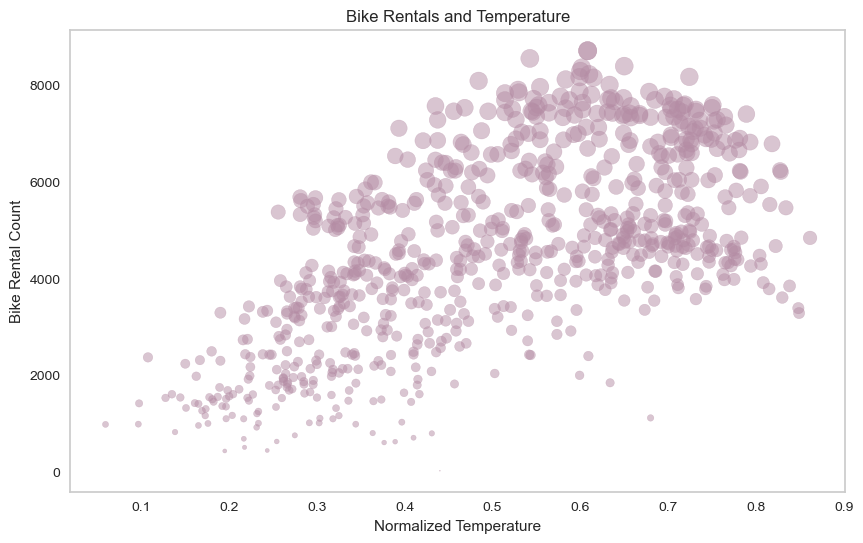

In [19]:
# Scatter plot with the relationship between temperature and bike rentals

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
size_factor = 0.02  # Set the size of the dots
plt.scatter(ds['temp'], ds['cnt'], s=ds['cnt'] * size_factor, alpha=0.5, color="#b58da5")  # alpha adds transparency

# Adding a title and labels
plt.title('Bike Rentals and Temperature')
plt.xlabel('Normalized Temperature')
plt.ylabel('Bike Rental Count')
plt.grid(False)  # Add grid lines for easier reading

# Show the plot
plt.show()

The same relationship between normalized temperature and total bike rentals is seen here as we saw with perceived temperature and bike rental activity.

C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\4062226643.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weathercondition', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#a57e96", "#F9C7D5", "#F7B1D3"])
C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\4062226643.py:3: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(x='weathercondition', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#a57e96", "#F9C7D5", "#F7B1D3"])


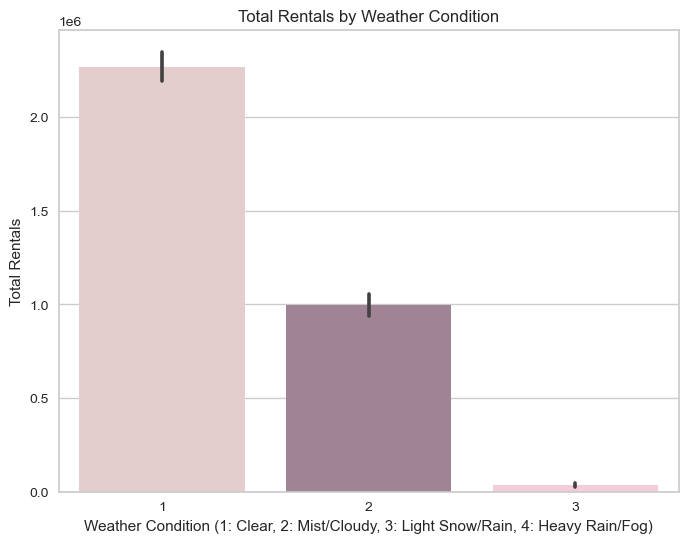

In [20]:
# Impact of weather conditions on total rentals
plt.figure(figsize=(8, 6))
sns.barplot(x='weathercondition', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#a57e96", "#F9C7D5", "#F7B1D3"])
plt.title('Total Rentals by Weather Condition')
plt.xlabel('Weather Condition (1: Clear, 2: Mist/Cloudy, 3: Light Snow/Rain, 4: Heavy Rain/Fog)')
plt.ylabel('Total Rentals')
plt.show()#F1C0D6"

In [21]:
ds[ds["weathercondition"] == 4].head()


,date,season,year,month,holiday,weekday,workingday,schoolday,weathercondition,temp,atemp,hum,windspeed,cnt


Looking at weather conditions, were observe that clear weather is the most favorable weather condition for bike rentals, with few rentals occurring under mist/cloudy conditions. There were no instances with heavy rain/fog in the given dataset.

In [22]:
cross_table_week = ds.pivot_table(values='cnt', index='weekday', aggfunc='sum')
cross_table_week

,cnt
weekday,
0.0,439146
1.0,455503
2.0,469109
3.0,473048
4.0,485395
5.0,482252
6.0,486521


Here we can see that the demand is very even throughout the week, thursday, friday and saturday are the days with the most rented bikes.

C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\3551870874.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#b58da5", "#F9C7D5", "#F7B1D3"])
C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\3551870874.py:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='weekday', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#b58da5", "#F9C7D5", "#F7B1D3"])


Text(0, 0.5, 'Total Rentals')

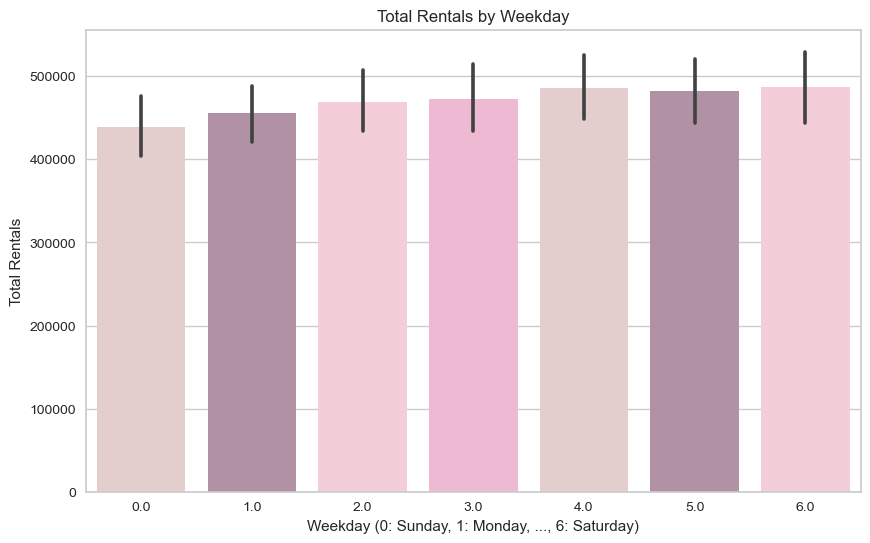

In [23]:
# Plotting weekday against cnt 

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='cnt', data=ds, estimator=sum, palette=["#e7c9c9", "#b58da5", "#F9C7D5", "#F7B1D3"])
plt.title('Total Rentals by Weekday')
plt.xlabel('Weekday (0: Sunday, 1: Monday, ..., 6: Saturday)')
plt.ylabel('Total Rentals')


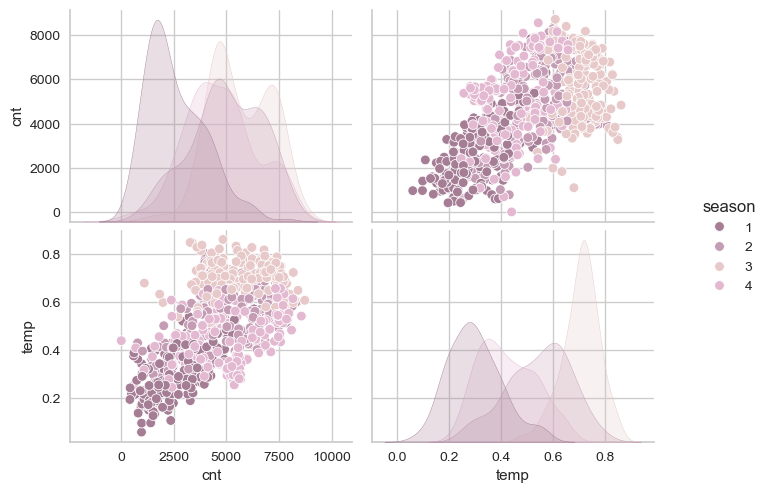

In [24]:
# Pair plot with some of the variables

# Draw
cols = ['date', 'cnt', 'temp', 'season']
g = sns.pairplot(ds[cols], hue='season', palette=["#a57e96", "#c49cb4", "#e7c9c9", "#e3b9d2"])
g.fig.set_size_inches(8,5)

The pair plot shows a positive correlation between temperature and rentals. As **temp** increases, so does **cnt**, confirming that warmer conditions encourage bike usage. The trend is stronger in summer and fall. This implies that temperature is a strong predictor of bike rental numbers and should be included in the model.
Spring(1) and winter(4) show lower temperatures and fewer bike rentals, whereas summer(2) and fall(3) have higher temperatures and more rentals.
The density distribution plots show a bimodal distribution, suggesting two demand peaks.

<Figure size 1000x600 with 0 Axes>

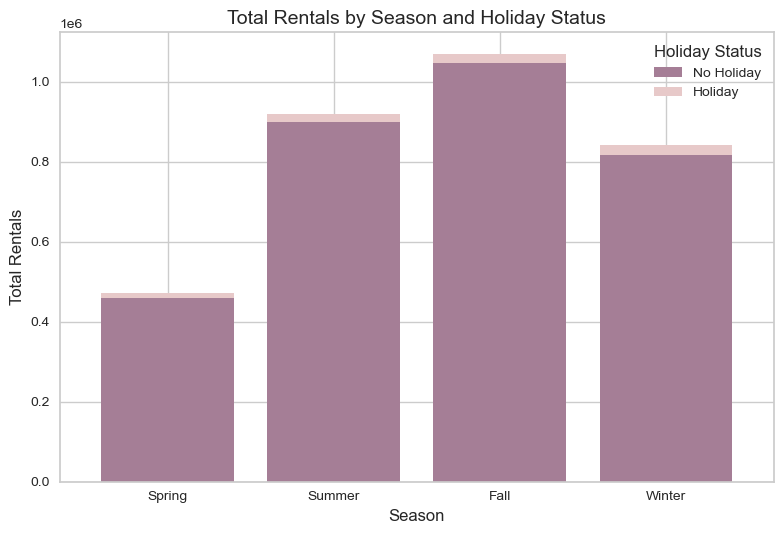

In [25]:
# Stacked bar plot with the total rentals by season and holiday status - APAGAR 

# Group the data by 'season' and 'holiday' and aggregate the total number of rentals
grouped_data = ds.groupby(['season', 'holiday'])['cnt'].sum().unstack()

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', stacked=True, color=["#a57e96", "#e7c9c9"], width=0.8)

# Adding labels and title
plt.title('Total Rentals by Season and Holiday Status', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.xticks(ticks=range(len(grouped_data.index)), labels=['Spring', 'Summer', 'Fall', 'Winter'], rotation=0)
plt.legend(title='Holiday Status', labels=['No Holiday', 'Holiday'])

# Show the plot
plt.tight_layout()
plt.show()

In this stacked bar chart, we can see that there are more rentals on “*off*” (No Holiday) days than on others. The season with the most rentals is fall (as we already know), followed by summer.

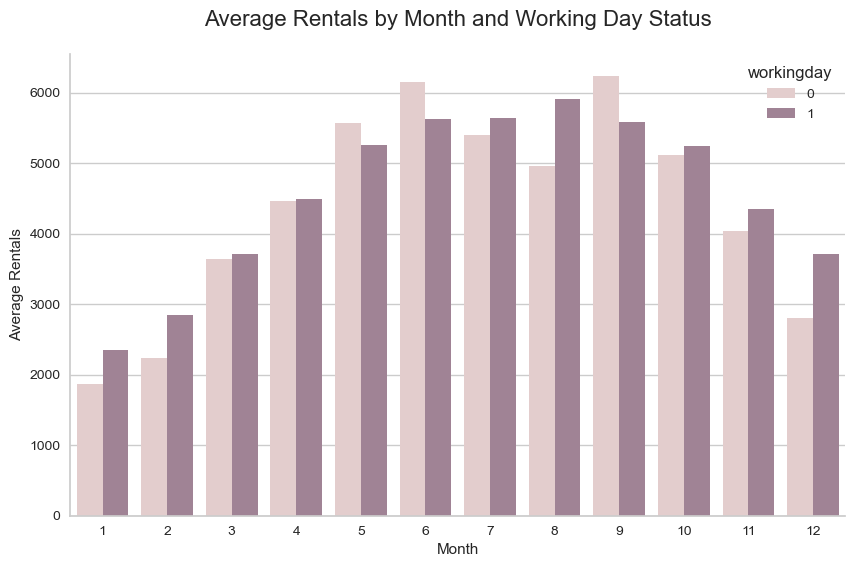

In [26]:
# Bar plot with the average rentals by working day status

# Grouping by month and workingday to calculate average rentals
tempDF = ds.groupby(['month', 'workingday'], observed=True).agg({'cnt': 'mean'}).reset_index()

# Pastel color palette
pastel_palette = ["#e7c9c9", "#a57e96"]  # Light pink and pastel purple shades

# Draw the bar plot with working day status as hue (color) to show the rental trends between working and non-working days
plt.figure(figsize=(10,6))
sns.barplot(data=tempDF, x="month", y="cnt", hue="workingday", palette=pastel_palette)

# Decoration
sns.despine()
plt.title("Average Rentals by Month and Working Day Status", fontsize=16, pad=20)  # Adjust 'pad' to move the title further from the plot
plt.xlabel("Month")
plt.ylabel("Average Rentals")
plt.rc('axes', labelsize=12)

# Adjusting the legend labels for working day status
handles, labels = plt.gca().get_legend_handles_labels()

The barplot shows that there's a higher demand for bikes on working days compared to non-working days, except for May, June and September. This could be due to the fact that people are more likely to rent bikes for commuting purposes during the week.

# 4. Data Preparation

In [27]:
# Create a modeling dataset from the original dataset

Z = ds.copy(deep=True)

### 4.1. Duplicates

In [28]:
# Identify all duplicate rows

duplicates = ds[ds.duplicated(keep=False)]

# Sort duplicates for easier analysis

duplicates_sorted = duplicates.sort_values(by=duplicates.columns.tolist())

# Display the sorted duplicated rows

print(f"Number of duplicated rows: {len(duplicates_sorted)}")
duplicates_sorted.info()

Number of duplicated rows: 2
<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 623 to 624
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2 non-null      datetime64[ns]
 1   season            2 non-null      int64         
 2   year              2 non-null      int64         
 3   month             2 non-null      int64         
 4   holiday           2 non-null      int64         
 5   weekday           2 non-null      float64       
 6   workingday        2 non-null      int64         
 7   schoolday         2 non-null      float64       
 8   weathercondition  2 non-null      int64         
 9   temp              2 non-null      float64       
 10  atemp             2 non-null      float64       
 11  hum               2 non-null      float64       
 12  windspeed         2 non-null      float64       
 13  cnt               2 non-null      int64         
dtypes:

In [29]:
# Display the number of duplicated rows

print(f"Number of duplicated rows: {len(duplicates_sorted)}")

# Display the sorted duplicated rows

print(duplicates_sorted)

Number of duplicated rows: 2
          date  season  year  month  holiday  weekday  workingday  schoolday  \
623 2012-09-15       3     1      9        0      6.0           0        0.0   
624 2012-09-15       3     1      9        0      6.0           0        0.0   

     weathercondition      temp     atemp       hum  windspeed   cnt  
623                 1  0.608333  0.585867  0.501667   0.247521  8714  
624                 1  0.608333  0.585867  0.501667   0.247521  8714  


In [30]:
# Drop the duplicates

Z = Z[~Z.duplicated(keep=False)]

We checked and dropped the unnecessary duplicates.

In [31]:
# Replace the values in 'weekday'

Z['weekday'] = Z['weekday'].replace({
    0.0: 0,
    1.0: 1,
    2.0: 2,
    3.0: 3,
    4.0: 4,
    5.0: 5,
    6.0: 6
})

Replacing the values of **weekday** from floating-points to integers is a crucial step to ensure the model correctly interprets the variable as a categorical feature. 

### 4.2. Outliers

In [32]:
# Function to detect outliers based on IQR

def detect_outliers(Z, column):
    Q1 = Z[column].quantile(0.25)
    Q3 = Z[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = Z[(Z[column] < lower_bound) | (Z[column] > upper_bound)]
    return outliers

# Check for outliers in each numerical column

numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
for col in numerical_columns:
    outliers = detect_outliers(Z, col)
    print(f"Outliers in {col}: {outliers.shape[0]}")

Outliers in temp: 0
Outliers in atemp: 0
Outliers in hum: 2
Outliers in windspeed: 13
Outliers in cnt: 0


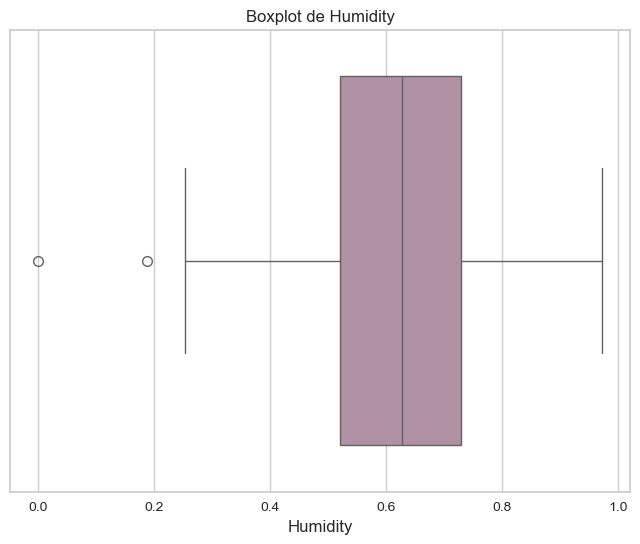

In [33]:
# Boxplot to see the outliers in humidity

plt.figure(figsize=(8, 6))
sns.boxplot(x=Z['hum'], color='#b58da5')
plt.title('Boxplot de Humidity')
plt.xlabel('Humidity')

plt.show()

**Plot Interpretation**
- The box represents the interquartile range (IQR) — the middle 50% of the humidity values.
- The line inside the box is the median (around 0.6 in this case).
- The "whiskers" (horizontal lines extending from the box) show the data range within 1.5 × IQR.
- The dots outside the whiskers are outliers — these are humidity values that are unusually low (below ~0.2 here)


In [34]:
# See the outliers in humidity

# Calculate the IQR (Interquartile Range)
Q1 = Z['hum'].quantile(0.25)
Q3 = Z['hum'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = Z[(Z['hum'] < lower_bound) | (Z['hum'] > upper_bound)]

# Check the first rows of the outliers
print(outliers.head())

         date  season  year  month  holiday  weekday  workingday  schoolday  \
49 2011-02-19       1     0      2        0      6.0           0        0.0   
68 2011-03-10       1     0      3        0      4.0           1        1.0   

    weathercondition      temp     atemp       hum  windspeed   cnt  
49                 1  0.399167  0.391404  0.187917   0.507463  1635  
68                 3  0.389091  0.385668  0.000000   0.261877   623  


Here we identified exactly what the two outliers were in order to treat them.

In [35]:
# Replace outliers with median value

humidity_median = Z['hum'].median()

# Replace the outliers (row 49 and 68)
Z.loc[49, 'hum'] = humidity_median
Z.loc[68, 'hum'] = humidity_median

# Verify the updated values
print(Z.loc[49])
print(Z.loc[68])


date                2011-02-19 00:00:00
season                                1
year                                  0
month                                 2
holiday                               0
weekday                             6.0
workingday                            0
schoolday                           0.0
weathercondition                      1
temp                           0.399167
atemp                          0.391404
hum                            0.627083
windspeed                      0.507463
cnt                                1635
Name: 49, dtype: object
date                2011-03-10 00:00:00
season                                1
year                                  0
month                                 3
holiday                               0
weekday                             4.0
workingday                            1
schoolday                           1.0
weathercondition                      3
temp                           0.389091
atemp           

We replaced outliers in the humidity data with the median to prevent these values from distorting the analysis or affecting model performance. 
The median is a robust central value that isn't influenced by outliers, making it a reliable choice for substitution. This approach allows us to clean the data while preserving its overall structure and size, ensuring more accurate and stable results.

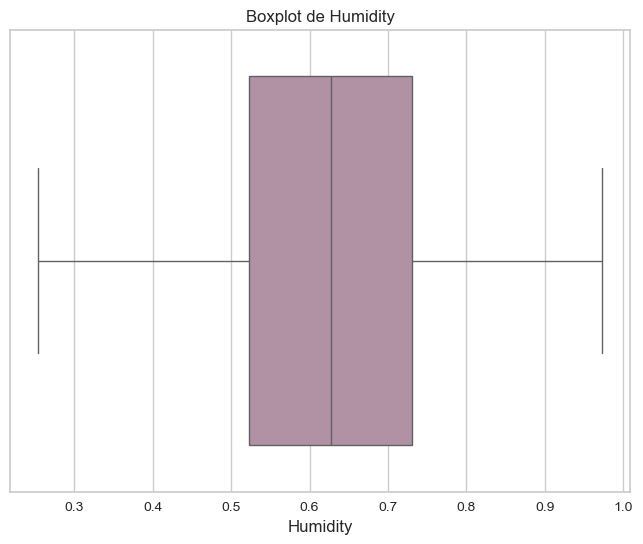

In [36]:
# Boxplot to check the humidity

plt.figure(figsize=(8, 6))
sns.boxplot(x=Z['hum'], color='#b58da5')
plt.title('Boxplot de Humidity')
plt.xlabel('Humidity')

plt.show()

After treating the outliers, we can see that the humidity data is now ready to be processed.

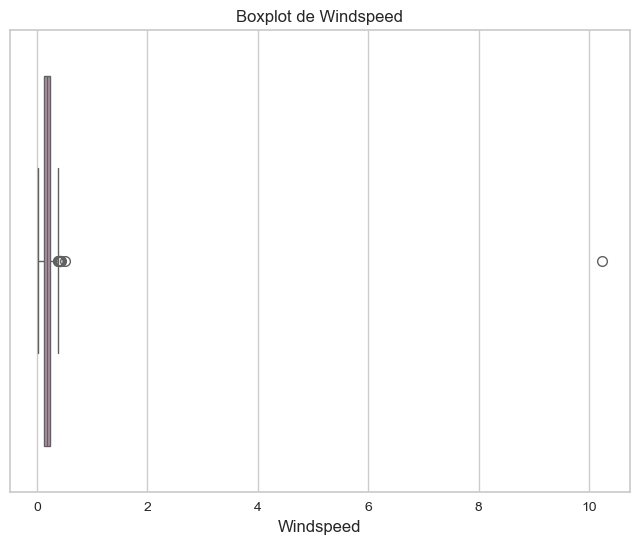

In [37]:
# Boxplot to see the outliers in windspeed

plt.figure(figsize=(8, 6))
sns.boxplot(x=Z['windspeed'], color='#b58da5')
plt.title('Boxplot de Windspeed')
plt.xlabel('Windspeed')

plt.show()

As we know that we have 13 outliers in windspeed, we decided to look at them before treating them. We can see that we have one extreme value and the other 12 values are close together.

In [38]:
# See the outliers in windspeed

# Calculate the IQR (Interquartile Range)
Q1 = Z['windspeed'].quantile(0.25)
Q3 = Z['windspeed'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = Z[(Z['windspeed'] < lower_bound) | (Z['windspeed'] > upper_bound)]

# Check the first rows of the outliers
print(outliers.head())

          date  season  year  month  holiday  weekday  workingday  schoolday  \
44  2011-02-14       1     0      2        0      1.0           1        1.0   
49  2011-02-19       1     0      2        0      6.0           0        0.0   
93  2011-04-04       2     0      4        0      1.0           1        0.0   
94  2011-04-05       2     0      4        0      2.0           1        0.0   
292 2011-10-20       4     0     10        0      4.0           1        NaN   

     weathercondition      temp     atemp       hum  windspeed   cnt  
44                  1  0.415000  0.398350  0.375833   0.417908  1913  
49                  1  0.399167  0.391404  0.627083   0.507463  1635  
93                  1  0.573333  0.542929  0.426250  10.234234  3115  
94                  2  0.414167  0.398350  0.642083   0.388067  1795  
292                 1  0.475833  0.466525  0.636250   0.422275  4195  


- The values of this variable must be between 0 and 1 because this variable normalized.

We've replaced the extreme outlier on windspeed with the median value, since we saw it was a input mistake
we checked the actual temperature: https://www.timeanddate.com/weather/usa/washington-dc/historic?month=4&year=2011

In [39]:
# Calculate the upper limit in the boxplot

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Calculate the upper limit (max value for boxplot)
upper_limit = Q3 + 1.5 * IQR

# Display the upper limit
print("Upper limit for boxplot:", upper_limit)

Upper limit for boxplot: 0.3805925


In [40]:
# Replace the outliers by the median

windspeed_median = Z['windspeed'].median()

Z.loc[Z['windspeed'] > upper_limit, 'windspeed'] = windspeed_median

We treated the other 12 values in the same way and replaced them with the median.

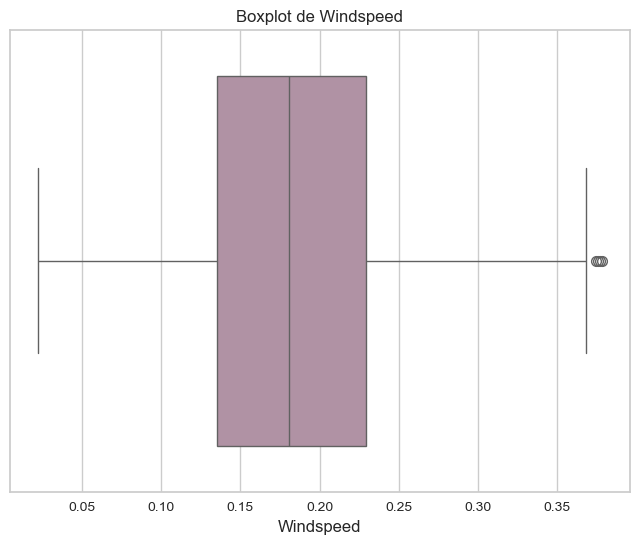

In [41]:
# Boxplot to check the windspeed

plt.figure(figsize=(8, 6))
sns.boxplot(x=Z['windspeed'], color='#b58da5')
plt.title('Boxplot de Windspeed')
plt.xlabel('Windspeed')

plt.show()

After treating the outliers, we can see that we still have some values outside the boxplot.

In [42]:
# See the outliers in windspeed
 
# Calculate the IQR (Interquartile Range)
Q1 = Z['windspeed'].quantile(0.25)
Q3 = Z['windspeed'].quantile(0.75)
IQR = Q3 - Q1
 
# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
 
# Identify outliers
outliers = Z[(Z['windspeed'] < lower_bound) | (Z['windspeed'] > upper_bound)]
 
# Check the first rows of the outliers
outliers.head()

,date,season,year,month,holiday,weekday,workingday,schoolday,weathercondition,temp,atemp,hum,windspeed,cnt
238,2011-08-27,3,0,8,0,6.0,0,NaN,2,0.680000,0.635556,0.850000,0.375617,1115
377,2012-01-13,1,1,1,0,5.0,1,1.0,1,0.274167,0.249362,0.507500,0.378108,3214
694,2012-11-24,4,1,11,0,6.0,0,NaN,1,0.278333,0.248742,0.404583,0.376871,2277
721,2012-12-21,1,1,12,0,5.0,1,1.0,2,0.326667,0.301767,0.556667,0.374383,3623


We decided to keep these values because they are still below our upper limit. 

### 4.3. Missing Values

In [43]:
# See the missing on 'weekday'

Z[Z['weekday'].isnull()][['date', 'weekday']]

,date,weekday
190,2011-07-10,NaN
195,2011-07-15,NaN


In [44]:
# Replace missing values with the correct values

Z.loc[190, 'weekday'] = 0  
Z.loc[195, 'weekday'] = 5 

As we have identified the missing values in the day of the week and know the exact date, we entered the correct day of the week on **weekday**.

### 4.4. Drop columns

In [45]:
# Drop columns that doesn't add value to the model

cols = ['date','schoolday','atemp']
Z = Z.drop(columns=cols)

We decided to drop **atemp** to avoid multicollinearity since we are already using the temp variable. **Schoolday** has too many missing values to be useful and we dropped **date** because it is a variable that is not helpfull for this case in specific.

### 4.5. Create new features

Since we want to know the total number of rented bikes for tomorrow, we have decided to create a new column called 'cnt_tom' that will contain the total number of rented bikes for the next day.

In [46]:
# Create the target variable by shifting 'cnt' up by one day
# This means the row for '2011-01-01' will have the 'cnt' value from '2011-01-03' as its target

Z['cnt_tom'] = Z['cnt'].shift(-2)


It creates a new column **cnt_tom** which represents the number of rented bikes 2 days ahead.
.shift(-2) moves the values up by 2 rows.

**Why are we applying this:**
We want to predict future demand. So, for example, for the row 2011-01-01, we assign the rental count of 2011-01-03 as its target.
This is useful if the dataset uses 2 days intervals so shift(-2) means "tomorrow"

In [47]:
# Shift actual weather back to simulate having tomorrow's weather available today

Z['temp_tom'] = Z['temp'].shift(-2)
Z['hum_tom'] = Z['hum'].shift(-2)
Z['windspeed_tom'] = Z['windspeed'].shift(-2)

In [48]:
# Drop rows with NaNs (at the end of the dataset from shifting)
Z = Z.dropna(subset=['cnt_tom', 'temp_tom', 'hum_tom', 'windspeed_tom'])

Our goal is to predict bike rentals for the next day. Therefore, we incorporate tomorrow's weather information (e.g., temperature) into our features by shifting these columns back one day. While using future data often constitutes leakage, this is justified here because reliable next-day weather forecasts are typically available in a real-world scenario. This required shift introduces NaN values in the last rows for these weather features, which we subsequently drop to maintain a clean dataset.

In [49]:
# Create a lag-1 feature for 'cnt' (previous day's rental count)

Z['cnt_lag1'] = Z['cnt'].shift(1)

# Create a lag-7 feature for 'cnt' (rental count from 7 days ago)
Z['cnt_lag7'] = Z['cnt'].shift(7)



Add lag features:
- cnt_lag1: Bike rentals yesterday.
- cnt_lag7: Bike rentals a week ago.

**Why are we applying this:**
- In time series, the past influences the future.
- These features capture temporal patterns.

In [50]:
# Handle NaN values created by shift (for the first few rows, lags will be NaN)
Z.fillna(method='bfill', inplace=True) # Or use other imputation methods for initial NaN values
# 'bfill' (backward fill) is often reasonable for lag features to fill the initial NaNs
# Another option is to fill with mean or median, or drop the first few rows with NaNs if dataset is large enough.

print(Z[['cnt', 'cnt_lag1', 'cnt_lag7']].head(10)) # Show first few rows with lag features

    cnt  cnt_lag1  cnt_lag7
0   985     985.0     985.0
1   801     985.0     985.0
2  1349     801.0     985.0
3  1562    1349.0     985.0
4  1600    1562.0     985.0
5  1606    1600.0     985.0
6  1510    1606.0     985.0
7   959    1510.0     985.0
8   822     959.0     801.0
9  1321     822.0    1349.0


C:\Users\djkim\AppData\Local\Temp\ipykernel_32256\2385393448.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Z.fillna(method='bfill', inplace=True) # Or use other imputation methods for initial NaN values


The code handles NaN values caused by the lagging operation using fillna(method='bfill', inplace=True) to perform backward filling, ensuring no missing values in the cnt_lag1 and cnt_lag7 columns. It prints the first 10 rows of the original column (cnt) and its lagged versions.

### 4.6. One hot encoding

In [51]:
Z.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 0 to 729
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            728 non-null    int64  
 1   year              728 non-null    int64  
 2   month             728 non-null    int64  
 3   holiday           728 non-null    int64  
 4   weekday           728 non-null    float64
 5   workingday        728 non-null    int64  
 6   weathercondition  728 non-null    int64  
 7   temp              728 non-null    float64
 8   hum               728 non-null    float64
 9   windspeed         728 non-null    float64
 10  cnt               728 non-null    int64  
 11  cnt_tom           728 non-null    float64
 12  temp_tom          728 non-null    float64
 13  hum_tom           728 non-null    float64
 14  windspeed_tom     728 non-null    float64
 15  cnt_lag1          728 non-null    float64
 16  cnt_lag7          728 non-null    float64
dtypes:

In [52]:
# Encode categorical features into dummy variables

cols = ['season', 'weekday']
X = pd.get_dummies(Z, columns=cols, drop_first=True)

One-point coding is especially useful for linear models (such as Linear Regression) that cannot deal directly with categorical variables.
It helps to avoid assuming any ordinal relationship between categories.
We tried coding **month** and **weather condition** but, after trying to create the model with these variables, we found that the model performs worse with this.

In [53]:
# Drop not used columns

cols = ['weathercondition', 'temp', 'hum','windspeed', 'cnt']
X = X.drop(columns=cols)

We eliminated **temp**, **hum**, **windspeed**, **cnt**, because we created some new features with these variables;

In [54]:
X.columns

Index(['year', 'month', 'holiday', 'workingday', 'cnt_tom', 'temp_tom',
       'hum_tom', 'windspeed_tom', 'cnt_lag1', 'cnt_lag7', 'season_2',
       'season_3', 'season_4', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0',
       'weekday_4.0', 'weekday_5.0', 'weekday_6.0'],
      dtype='object')

### 4.7. Target and Features

In [55]:
# Define the target and the features for the model (linear regression)

y = X['cnt_tom']  # Target
X = X[['year', 'holiday', 'workingday', 'temp_tom', 'hum_tom', 'windspeed_tom',
       'cnt_lag1', 'cnt_lag7', 'season_2', 'season_3', 'season_4',
       'weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0',
       'weekday_5.0', 'weekday_6.0']] #Features

We chose our target and the characteristics. In the features, we eliminated some of the variables: 
- We eliminated **cnt_tom** because it is our target;
- We eliminated **month** because **month** and **season** have a high correlation and, for this reason, our model works well without this variable (we tried running the model with and without this variable and the result is better without it).

### 4.8. Normalize the columns

In [56]:
# Normalize all columns

X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

The code normalizes all columns of the DataFrame X using MinMaxScaler, scaling the values between 0 and 1. This ensures that each feature contributes equally during analysis by mitigating the impact of differing scales.

In [57]:
# Summary statistics for all variables after data preparation - Transpose

X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
year,728.0,0.498626,0.500342,0.0,0.000000,0.000000,1.000000,1.0
holiday,728.0,0.028846,0.167489,0.0,0.000000,0.000000,0.000000,1.0
workingday,728.0,0.685440,0.464660,0.0,0.000000,1.000000,1.000000,1.0
temp_tom,728.0,0.543886,0.228313,0.0,0.345564,0.548307,0.743521,1.0
hum_tom,728.0,0.522080,0.194336,0.0,0.373404,0.519142,0.662558,1.0
windspeed_tom,728.0,0.460394,0.200213,0.0,0.316000,0.445797,0.582161,1.0
cnt_lag1,728.0,0.525283,0.226419,0.0,0.370473,0.530470,0.694246,1.0
cnt_lag7,728.0,0.524726,0.227155,0.0,0.370473,0.530470,0.694246,1.0
season_2,728.0,0.252747,0.434886,0.0,0.000000,0.000000,1.000000,1.0
season_3,728.0,0.256868,0.437206,0.0,0.000000,0.000000,1.000000,1.0


# 5. Modeling

### 5.1. Linear Regression

In [58]:
# Split the dataset intro train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 42)

This code splits the dataset into training and testing sets using the train_test_split function. X represents the independent variables, and y represents the dependent variable. The dataset is split such that 75% of the data is used for training (train_size=0.75) and 25% is used for testing (test_size=0.25). random_state=42 ensures that the split is reproducible.

In [59]:
# Initialize model

lr_regr = linear_model.LinearRegression()

This code initializes a linear regression model using the LinearRegression class from the linear_model module. lr_regr is an instance of the linear regression model, which will be trained using the training data and used to make predictions on the test data.

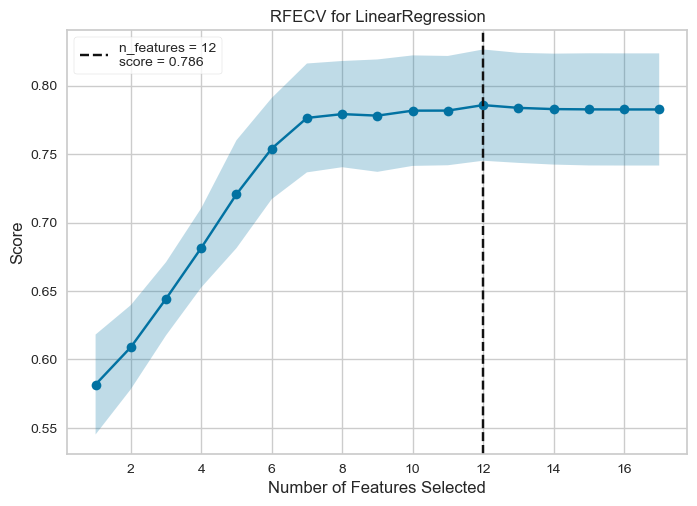

<Axes: title={'center': 'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [60]:
# Apply RFECV (Recursive Feature Elimination) to select features

vis = RFECV(lr_regr, cv=5, scoring='r2')
vis.fit(X_train, y_train)
vis.show()

This plot displays the results of Recursive Feature Elimination with Cross-Validation (RFECV) for a Linear Regression model, showing the cross-validated performance score against the number of selected features. The analysis indicates that model performance generally improves as more features are included, reaching its maximum score of approximately 0.786 when 12 available features are used, suggesting that retaining this features is optimal for this specific model and dataset according to the cross-validation results.

In [61]:
# Features to include (all in this case)

X.columns[vis.support_]

Index(['year', 'holiday', 'temp_tom', 'hum_tom', 'windspeed_tom', 'cnt_lag1',
       'cnt_lag7', 'season_2', 'season_3', 'season_4', 'weekday_5.0',
       'weekday_6.0'],
      dtype='object')

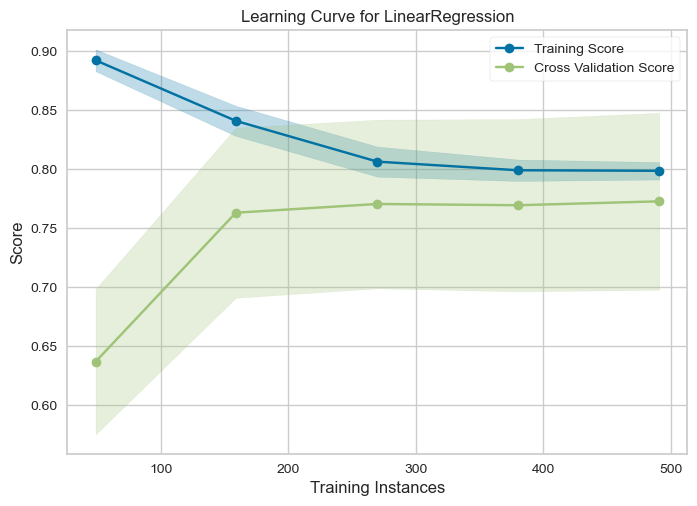

<Axes: title={'center': 'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [62]:
# Define the number of folds in cross-validation
cv = 10

# Define training sizes (10% to 100% of the data)
sizes = np.linspace(0.1, 1.0, 5)

# Create the learning curve plot
visualizer = LearningCurve(
    estimator=lr_regr,  # Linear regression model
    cv=cv,              # Cross-validation with 10 folds
    scoring='r2',       # Evaluation metric (R²)
    train_sizes=sizes,  # Percentage of training data used
    n_jobs=4,           # Use multiple cores for processing
    random_state=42    # Reproducibility
)

# Fit and display the learning curve
visualizer.fit(X_train, y_train)
visualizer.show()

This learning curve for the Linear Regression model plots the R² score against varying training set sizes. The training score starts high and slightly decreases to stabilized around 0.81, while the cross-validation score starts lower and increases, appearing to level off near 0.78 as more training instances are added. The persistent gap between the two curves suggests the model exhibits moderate variance  and the plateauing cross-validation score indicates that while more data might offer marginal gains, the model might also have some bias. 

In [63]:
# Create and train the model

lr_regr.fit(X_train, y_train)

LinearRegression()

In [64]:
# Print the Intercept

print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 1822.2083016152365 



,Feature,Coefficient,AbsCoefficient
3,temp_tom,3817.809592,3817.809592
4,hum_tom,-2025.305709,2025.305709
0,year,1588.432164,1588.432164
5,windspeed_tom,-1249.877378,1249.877378
10,season_4,1194.295482,1194.295482
6,cnt_lag1,1088.994567,1088.994567
8,season_2,870.674322,870.674322
9,season_3,517.289694,517.289694
7,cnt_lag7,463.612113,463.612113
15,weekday_5.0,-353.097999,353.097999


The coefficient figures reveal that temperature has the strongest positive effect on bike rentals (temp_tom: coefficient + 3817.81). As temperature increases, bike rentals increase substantially. Humidity negatively impacts rentals (coefficient: -2025.31). High humidity seems to discourage people from biking, possibly due to the discomfort. Windy conditions lead to fewer rentals (-1249.88), as expected, since strong winds make biking more difficult and less pleasant. Weather appears to be the dominant factor in predicting bike rentals. Some seasonality and weekday patterns exist but with smaller effects, as indicated by the relatively low coefficients for the season and weekday attributes.

In [65]:
# Evaluate the model

lr_regr.score(X_test, y_test)

0.7980202043565202

A score of 0.798 indicates that our linear regression model captures a significant portion (79.8%) of the variability in the target variable in the test data. This suggests a good level of predictive power, although there is still some variance that the model does not explain.

# 6. Evaluation - Linear Regression

In [66]:
# predict y for X_train and X_test

y_pred_train = lr_regr.predict(X_train) 
y_pred_test = lr_regr.predict(X_test) 

In [67]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [68]:
# Show performance results

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,626.618557,641.344559
1,RMSE,852.383762,891.009420
2,R^2,0.797650,0.798020
3,MAPE (%),0.188186,1.390809
4,MAX Error,3829.641452,4678.146303


Our linear regression model achieved a Mean Absolute Error (MAE) of *626.62* on the training data and *641.34* on the testing data, representing the average absolute difference between predictions and actual values. The Root Mean Squared Error (RMSE), which gives more weight to larger errors, is *852.38* for the training set and *891.01* for the test set. The R-squared value of *0.7977* (training) and *0.798*(testing) indicates that the model explains a high proportion of the variance in the target variable. The Mean Absolute Percentage Error (MAPE) is low at *0.188%* (training) and *1.39%* (test). However, the Maximum Error of *3829.64* (training) and *4678.15* (testing) reveals the presence of some large individual prediction errors.


c:\Users\djkim\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


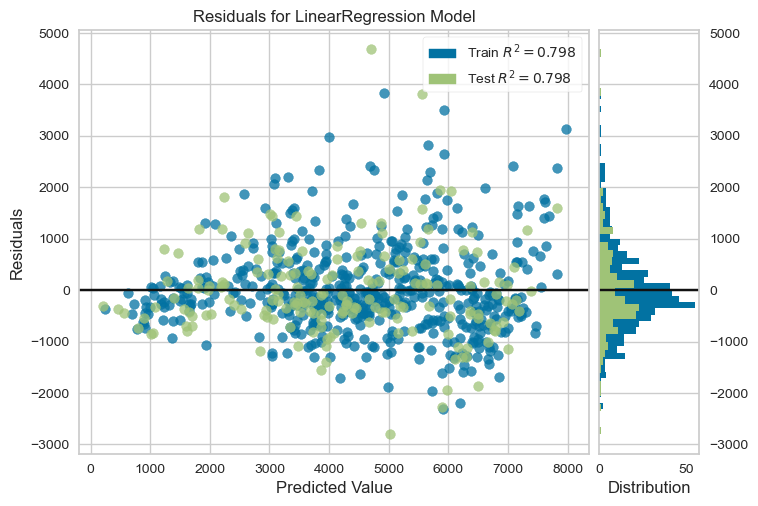

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [69]:
# Visualize the residuals

residuals_vis = ResidualsPlot(lr_regr)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

This graph shows that the Linear Regression model performs consistently on both training and test data. The residuals are mostly centered around zero and randomly scattered, which suggests the model is not biased and that a linear approach is appropriate. The similar R² values (0.798 for train and 0.798 for test) indicate strong generalization and low risk of overfitting. The histogram shows a roughly normal distribution of residuals, supporting the model's reliability and accuracy.

c:\Users\djkim\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


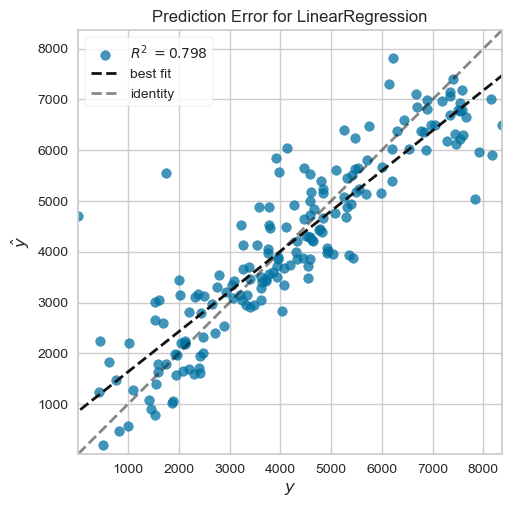

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [70]:
# Visualize the prediction error

predError_vis = PredictionError(lr_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show() 

This graph shows that the model's predictions closely match the actual values, as most points lie near the identity line. The R² score of 0.798 confirms strong performance, with the model explaining about 80% of the variance. Overall, it suggests accurate and consistent predictions.

## Save model to use in deployment

In [71]:
import pickle
file = open("model.pickle", "wb")
pickle.dump(lr_regr, file)
file.close()